# Memorial Tunnel Backlayering Analysis

Conor Fleming, 30th July 2020

# Introduction

Calculation sheet comparing Memorial Tunnel data against the Li & Ingason model for confinement/critical velocity.

# Calculation Sheet Setup
 * Import libraries for plotting, array operations, spreadsheets, images.
 * Set styles and in-line plotting

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import Image

In [46]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [47]:
%matplotlib inline

# Define Conditions

Memorial Tunnel conditions.

## Height

Sum vertical distances from drawing (in feet) and convert to metres.
False ceiling was removed for jet fan tests.

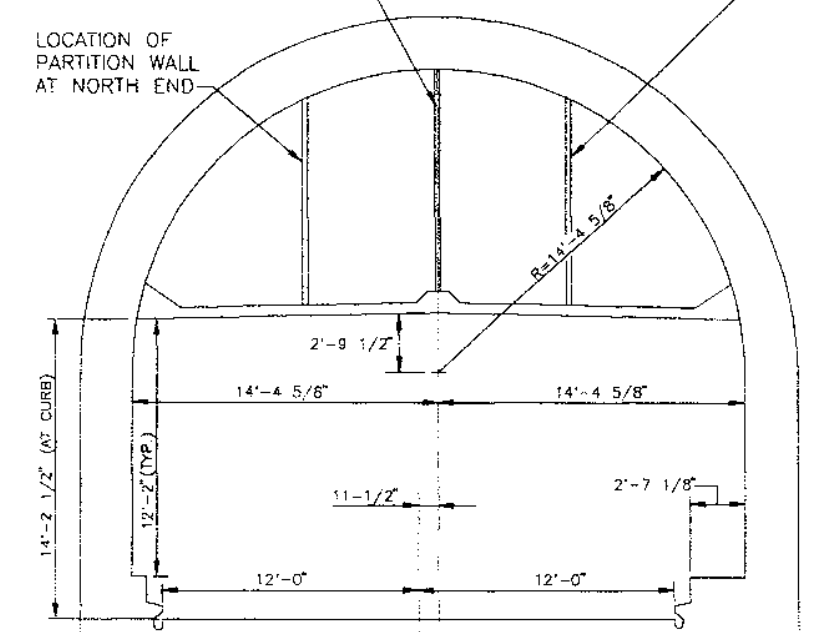

In [48]:
Image('tunnel_section.png', width=500)

In [49]:
H_tun = (14 + 2.5/12 - (2 + 9.5/12) + 14 + 4.625/12) * 0.3048
H_tun

7.864475000000001

**Note:** Li & Ingason don't distinguish between plume height and tunnel height in their 2010 paper, as they are the same.
This is not the case for the Memorial Tunnel, where the fuel pans were elevated above the road.
The analysis is based on a ratio of longitudinal momentum vs bouyancy, which is driven by plume height, not total tunnel height. 
Hence plume height is adopted for this calculation.

In [50]:
H_fuel = 0.76
H = H_tun - H_fuel
H

7.104475000000002

## Ambient conditions

In [51]:
rho = 1.2
cp = 1000
T = 293
g = 9.81

## Gradient

In [52]:
m = 0.032

# Memorial Tunnel Data

Taken from Kile & Gonzalez (1997)

In [53]:
memorial = pd.read_csv('kile_gonzalez_1997_data.csv')
memorial

,Test,Q [MW],u [fpm],Backlayering
0,617a,8.5,437,no
1,617a,9.1,463,no
2,606a,9.3,250,yes
3,617a,10.6,523,no
4,606a,11.4,467,no
5,618a,11.5,539,no
6,618a,13.1,279,yes
7,607,13.8,323,yes
8,607,15.6,513,no
9,618a,17.6,282,yes


Filter out low heat release rate data, which is not a primary concern for road tunnels.
In the Li & Ingason model this is where $Q^*<0.15$, or for Memorial Tunnel conditions, $Q \lessapprox 22$ MW.

In [54]:
memorial = memorial[memorial['Q [MW]'] > 22]
memorial

,Test,Q [MW],u [fpm],Backlayering
10,612b,43.7,392,yes
11,610,47.9,401,yes
12,612b,50.3,547,no
13,624b,50.3,571,no
14,611,51.2,570,no
15,610,52.4,617,no
16,610,53.7,576,no
17,621a,78.0,394,yes
18,621a,94.8,542,no
19,625b,106.8,572,no


Filter out controlled and uncontrolled cases

In [55]:
mem_unc = memorial[memorial['Backlayering']=='yes']
mem_ctr = memorial[memorial['Backlayering']=='no']

Convert HRR to watts

In [56]:
Q_mem_unc = mem_unc['Q [MW]']*1e6
Q_mem_ctr = mem_ctr['Q [MW]']*1e6

Convert velocity to m/s

In [57]:
V_mem_unc = mem_unc['u [fpm]']*0.3048/60
V_mem_ctr = mem_ctr['u [fpm]']*0.3048/60

Apply the Atkinson & Wu slope correction,

$$ V_\mathrm{c} = \frac{V_\mathrm{c\,s}}{1 + 0.014 \theta }$$

where $\theta$ is the slope in degrees, which can be calculated as $\tan^{-1} m$ where $m$ is the gradient.

**Note:** In their 2010 study, Ingason & Li were free to choose what they thought was the most appropriate slope model. Whether the NFPA 502 / Bakke & Leach (1960) model is better than the Atkinson & Wu mdoel is a question in itself.

In [58]:
V_mem_unc = V_mem_unc / (1 + 0.014*np.rad2deg(np.arctan(m)))  
V_mem_ctr = V_mem_ctr / (1 + 0.014*np.rad2deg(np.arctan(m)))  

Non-dimensionalize the heat release rate

$$Q^* = \frac{Q}{\rho c_\mathrm{p} T g^{1/2} H^{5/2}}$$

In [59]:
Q_star_mem_ctr = Q_mem_ctr / (rho * cp * T * g**0.5 * H**(5/2))
Q_star_mem_unc = Q_mem_unc / (rho * cp * T * g**0.5 * H**(5/2))

Non-dimensionalize the velocity

$$ V^* = \frac{V}{\sqrt{g H}}$$

In [60]:
V_star_mem_unc = V_mem_unc / np.sqrt(g * H)
V_star_mem_ctr = V_mem_ctr / np.sqrt(g * H)

# Li & Ingason Model

**Note:** We are ignoring the low range of heat release rates, where $Q^*<0.15$ ($Q \lessapprox 22$ MW for Memorial Tunnel conditions).

Set up solution space for ranges of non-dimensional heat release rate, $10^{-1} < Q^* < 10^0$, and velocity, $10^{-1} < V^* < 10^0$

In [61]:
Q_star_grid, V_star_grid = np.meshgrid(np.logspace(-1, 0),
                                       np.logspace(-1, 0))

Calculate backlayering length in the solution space.

$$ l^* = 18.5 \ln \left( \frac{0.43}{V^*} \right)$$

In [62]:
l_star_grid = 18.5 * np.log(0.43/V_star_grid)

# Plot data

## Non-dimensionalized terms on log-log scale

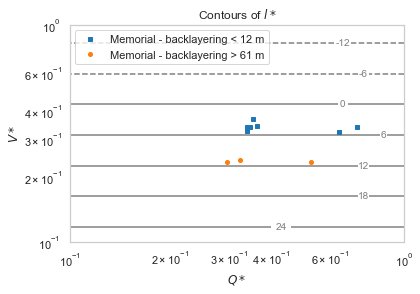

In [63]:
fig, ax = plt.subplots()

C = ax.contour(Q_star_grid, V_star_grid, l_star_grid, colors='grey')
plt.clabel(C, inline=1, fontsize=10, fmt='%.0f')

ax.plot(Q_star_mem_ctr, V_star_mem_ctr, 's', ms=4, label='Memorial - backlayering < 12 m')
ax.plot(Q_star_mem_unc, V_star_mem_unc, 'o', ms=4, label='Memorial - backlayering > 61 m')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim((0.1, 1))
plt.ylabel('$V*$')
plt.xlabel('$Q*$')

plt.title('Contours of $l*$')
plt.legend(loc='upper left')

### Observation

The Memorial Tunnel data falls below the critical velocity line ($l^* = 0$) by about $l^*=6$.
The same data is plotted with dimensions to assess the distance.

## Dimensional form on linear scale

Convert solution space and backlayering contours to dimensional form.

In [64]:
Q_grid = Q_star_grid * rho*cp*T*g**0.5*H**(5/2) / 1e6
V_grid = V_star_grid * np.sqrt(g*H)

**Note:** The height used for non-dimensionalizing $l^*$ is not clear, as in the original research the plume height and tunnel height were the same. 
The plume height is used here, for consistency with the definitions of $V^*$ and $Q^*$.

In [65]:
l_grid = l_star_grid * H

Plot data

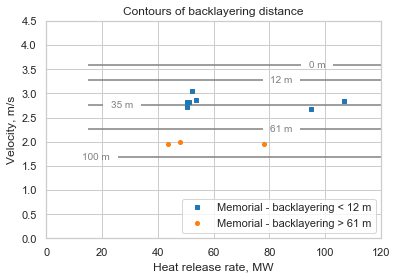

In [66]:
fig, ax = plt.subplots()
C = ax.contour(Q_grid, V_grid, l_grid, colors='grey', levels=[0, 12, 35, 61, 100])
ax.plot(Q_mem_ctr/1e6, V_mem_ctr, 's', ms=4, label='Memorial - backlayering < 12 m')
ax.plot(Q_mem_unc/1e6, V_mem_unc, 'o', ms=4, label='Memorial - backlayering > 61 m')
plt.clabel(C, inline=1, fontsize=10, fmt='%.0f m',)
plt.grid('on')
plt.ylim(0, 4.5)
plt.xlim(0, 120)
plt.ylabel('Velocity, m/s')
plt.xlabel('Heat release rate, MW')
plt.title('Contours of backlayering distance')
plt.legend(loc='lower right')
plt.savefig('li_ingason_model_memorial_data.png', dpi=300)

###  Observations

The above plot indicates the degree of backlayering predicted by the Li & Ingason model for each of the Memorial Tunnel data points in the range $Q > 22$ MW.

It is interesting to note that none of the 'controlled' points land in the zone $l_\mathrm{backlayer} < 12$ m, even though it was reported that most of these points were observed to backlayer by less than 12 m.

The 'uncontrolled' cases above 22 MW are predicted to backlayer by just under 61 m, whereas the experimental report deemed these cases to backlayer for more than 200 ft / 61 m.
